<image src="https://i3.wp.com/upload-images.jianshu.io/upload_images/7893619-d32a04065e1d2d7f">

# 0. Описать задачу словами

В данном датасете по обзорам вин от сомелье будем предсказывать сорт винограда, из которого было произведено вино (задача классификации). Данные были взяты с *WineEnthusiast*.

Признаки:
* `country` - страна, в которой произведено вино.
* `description` - описание вина.
* `designation` - виноградник на территории винодельни, из винограда которого делается вино.
* `points` - оценка вина на *WineEnthusiast* по шкале от 1 до 100.
* `price` - цена за бутылку.
* `province` - провинция или штат, откуда вино.
* `region_1` - винодельческий район в провинции или штате.
* `region_2` - более конкретный регион в винодельческой области (редко указывается).
* `taster_name` - имя сомелье.
* `taster_twitter_handle` - его *twitter*.
* `title` - заголовок винного обзора.
* `variety` - сорт винограда, используемый в изготовлении вина.
* `winery` - винодельна, которая произвела вино.

# 1. Прочитать данные

В данном разделе импортируем необхыдимые библиотеки, затем загружаем данные.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("winemag-data-130k-v2.csv", index_col=0)
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Прежде чем продолжить работу, стоит убрать некоторые признаки, которые либо несут избыточную информацию (например, штат и регионы), либо не несут полезной информации (например, имя и твиттер сомелье). Также в нашей задаче не понадобится признак `points`, так как это оценка вина по мнению сомелье (в дадастете представлены вина с оценкой 80+/100)

In [3]:
columns = ["country", "description", "price", "variety"]
data = data[columns]
data.head()

,country,description,price,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",NaN,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Pinot Noir


In [4]:
data.shape

(129971, 4)

In [5]:
data.variety.unique().size

708

# 2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.


In [6]:
data.describe()

,price
count,120975.000000
mean,35.363389
std,41.022218
min,4.000000
25%,17.000000
50%,25.000000
75%,42.000000
max,3300.000000


In [7]:
data.describe(include=['object'])

,country,description,variety
count,129908,129971,129970
unique,43,119955,707
top,US,"Seductively tart in lemon pith, cranberry and ...",Pinot Noir
freq,54504,3,13272


In [8]:
print("Количество пропущенных значений:", data.isna().sum(), sep='\n', end='\n\n')
print("Процент пропущенных значений:", (data.isna().sum() / data.shape[0]) * 100, sep='\n')

Количество пропущенных значений:
country          63
description       0
price          8996
variety           1
dtype: int64

Процент пропущенных значений:
country        0.048472
description    0.000000
price          6.921544
variety        0.000769
dtype: float64


В нашем датасете достаточно много пропущенных значений у признака цены, относительно других признаков, также максимальной значение очень сильно отличается от квантилей (возможно выброс). Построим гистограмму для этого признака.

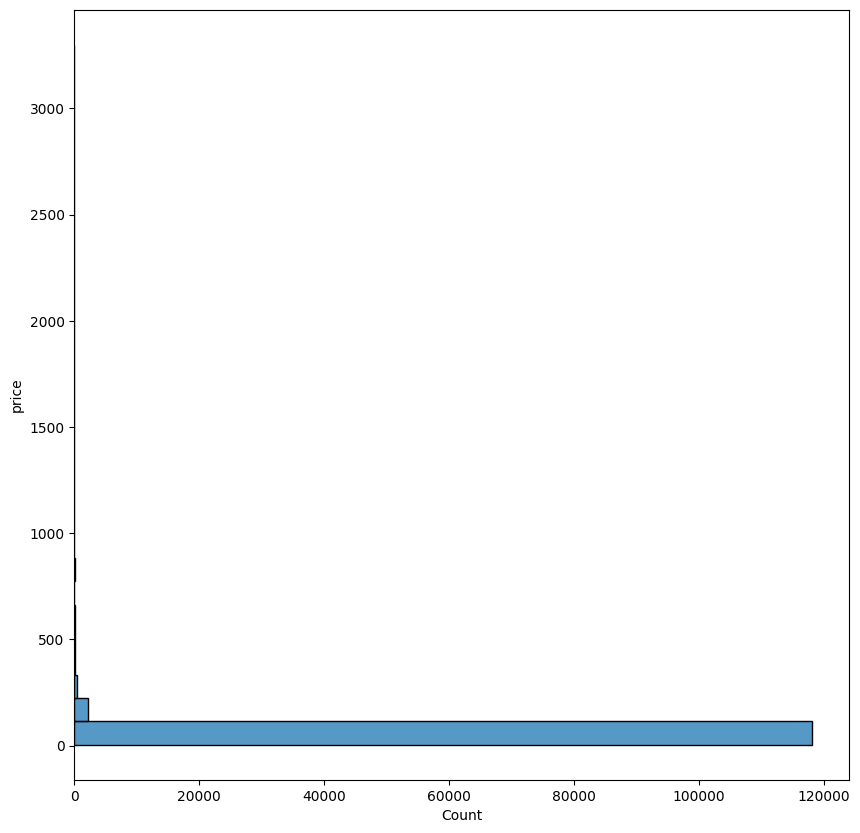

In [9]:
plt.figure(figsize=(10, 10))
sns.histplot(data, y='price', bins=30)
pass

Значения с ценой выше $500$ выбиваются из общей динамики, возможно и есть вина с такой ценой, но они очень редкие, поэтому относительно нашей задачи будем считать их выбросами и на следующей стадии избавимся от таких значений цены.

Посмотрим на сорт винограда, выбранный нами целевой признак. Некоторые сорты очень редко встречаются, поэтому выберем те которые встречаются хотя бы $100$ раз в нашем датасете.

92

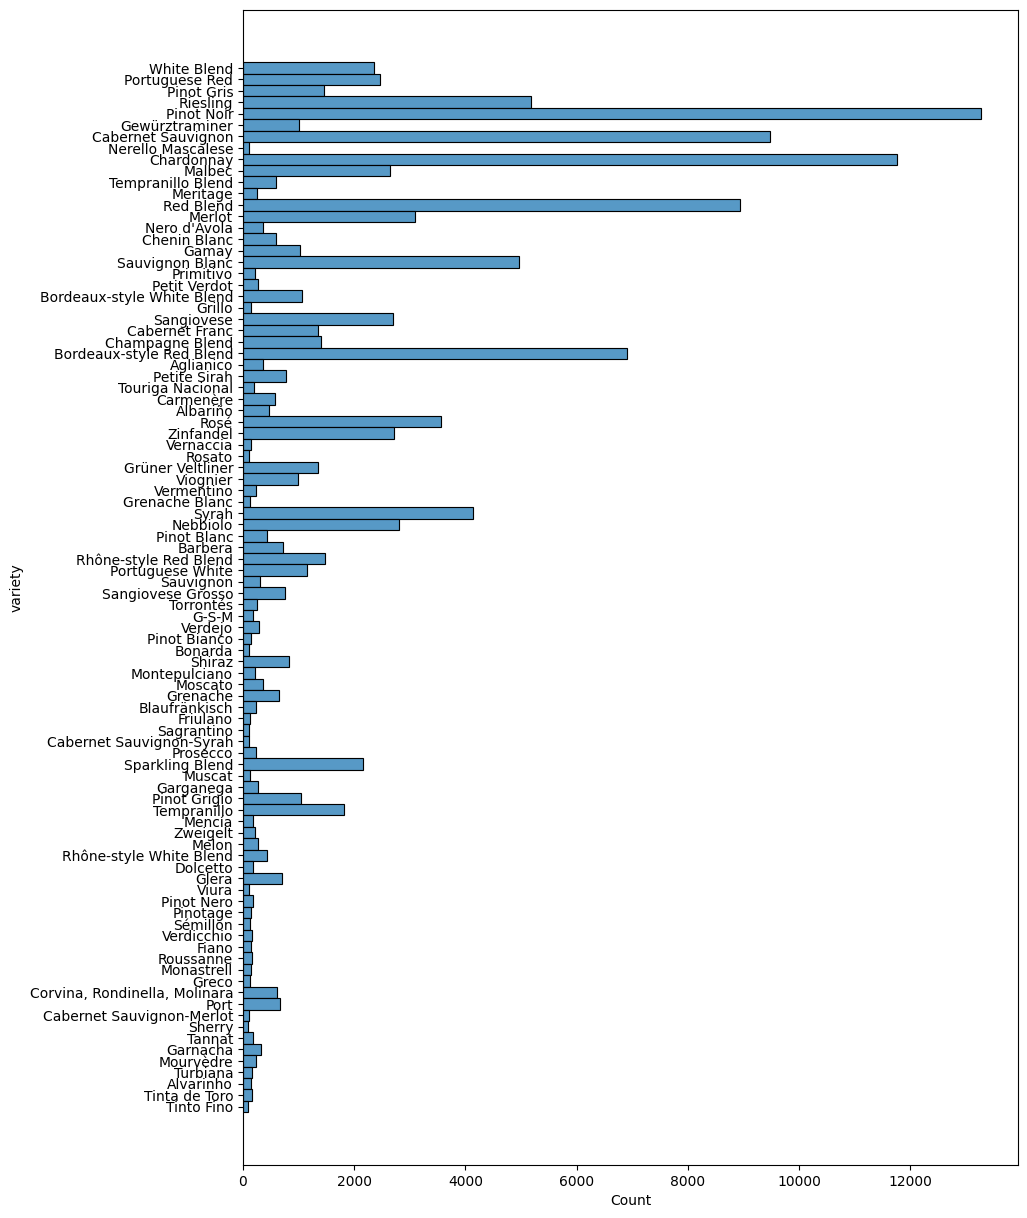

In [10]:
variety_values = data.variety.value_counts()
most_frequent_varieties = variety_values[variety_values >= 100]

plt.figure(figsize=(10, 15))
sns.histplot(data[data.variety.apply(lambda x: x in most_frequent_varieties.index)], y='variety')

most_frequent_varieties.size

# 3. Обработать пропущенные значения (или убедиться, что их нет)

Для начала выберем те запbси, которые удовлетворяют следующим условиям:
* записей с таким же сортом винограда $100 \le cnt \le 500$.
* цена за бутылку не превосходит $500$.

In [11]:
price_less_than_500 = data.price <= 500
data = data[price_less_than_500]

df = pd.DataFrame(columns=data.columns)
variety_values = data.variety.value_counts()
for variety, group in data.groupby('variety'):
    if (variety_values[variety] >= 500):
        cur_group = group.loc[np.random.choice(group.index, 500, False)]
    elif (variety_values[variety] >= 100):
        cur_group = group
    else:
        continue

    if df.empty:
        df = cur_group
    else:
        df = pd.concat([df, cur_group], axis=0)

df

,country,description,price,variety
72,Italy,"Aromas of black-skinned fruit, leather, underb...",32.0,Aglianico
769,Italy,"Here's a jammy, overtly ripe expression of Agl...",30.0,Aglianico
2573,Italy,This fragrant red opens with lovely scents of ...,20.0,Aglianico
2726,Italy,Made with white vinification of Aglianico grap...,30.0,Aglianico
3001,Italy,"Small red berry, spring flower, bread crust an...",43.0,Aglianico
...,...,...,...,...
126955,Austria,"On the earthy side of Zweigelt, this is a firm...",17.0,Zweigelt
127419,Austria,"From the Heideboden vineyard, this mineral, st...",17.0,Zweigelt
128705,Austria,"Toasty oak and backed structure appear first, ...",25.0,Zweigelt
129218,US,Quite possibly the first and only Washington Z...,29.0,Zweigelt


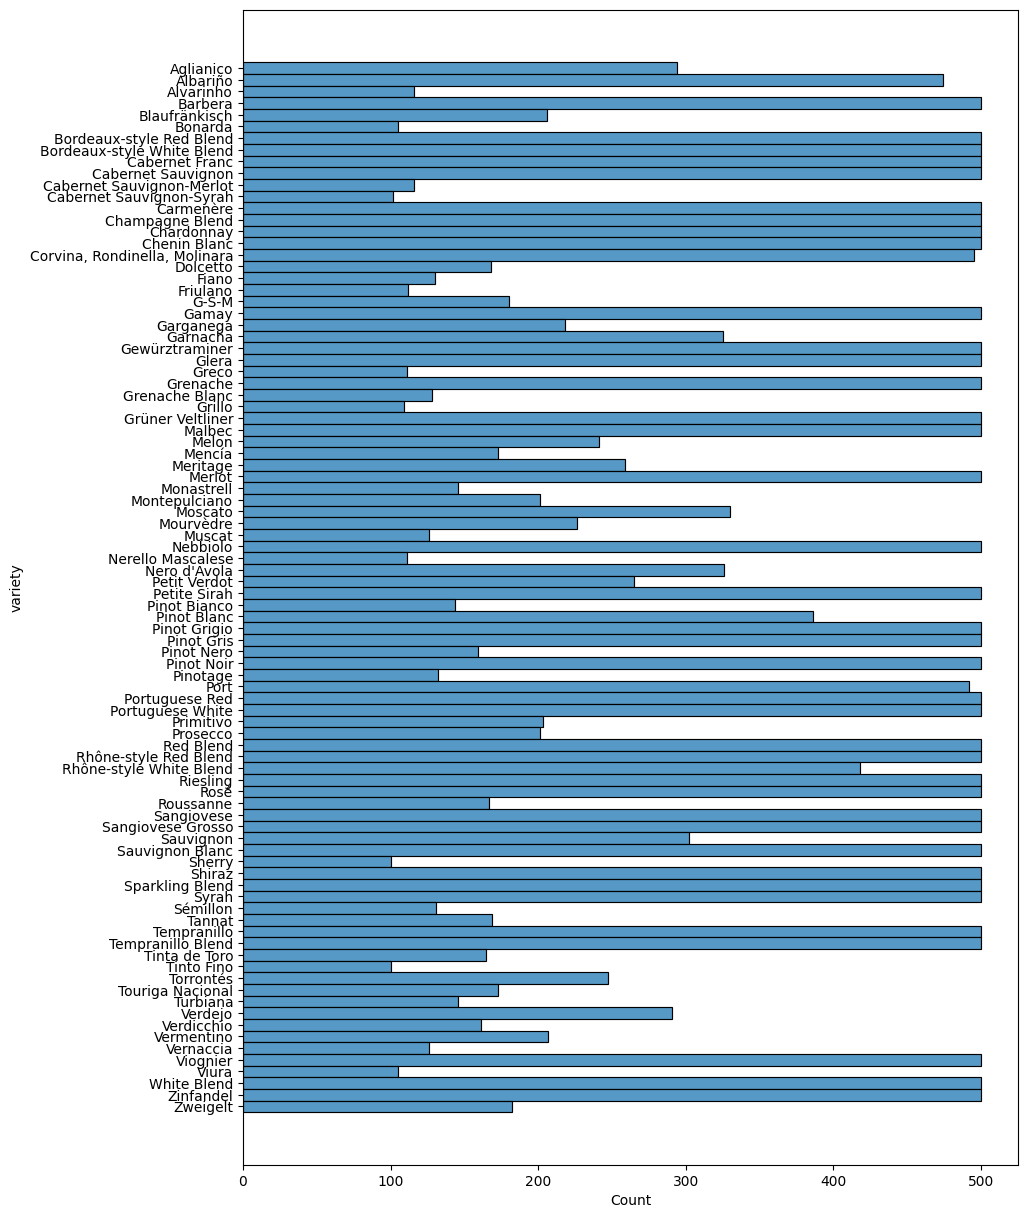

In [12]:
plt.figure(figsize=(10, 15))
sns.histplot(df, y='variety')
pass

In [13]:
data = df

In [14]:
print("Количество пропущенных значений:", data.isna().sum(), sep='\n', end='\n\n')
print("Процент пропущенных значений:", (data.isna().sum() / data.shape[0]) * 100, sep='\n')

Количество пропущенных значений:
country        6
description    0
price          0
variety        0
dtype: int64

Процент пропущенных значений:
country        0.020202
description    0.000000
price          0.000000
variety        0.000000
dtype: float64


Пропущенные значения у нас остались только в признаке страны, которые мы заменим на наиболее часто встречающиеся.

In [15]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(data[['country']])

data[['country']] = imputer.transform(data[['country']])

In [16]:
print("Количество пропущенных значений:", data.isna().sum(), sep='\n', end='\n\n')

Количество пропущенных значений:
country        0
description    0
price          0
variety        0
dtype: int64



# 4. Обработать категориальные признаки

В этом пункте нам предстоит обработать категориальный признак `country` и провести векторизацию текстового признака `description`.

Для признака `country` воспользуемся кодировкой *OneHot*. Для `description` - *Term frequency - inverse document frequency*.

In [17]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(data[['country']])

countries_sparse_matrix = encoder.transform(data[['country']])
# country_df = pd.DataFrame(countries_sparse_matrix.toarray(), columns=encoder.get_feature_names_out(), index=data.index)

Посмотрим на облоко слов, которые встречаются в обзорах на вина.

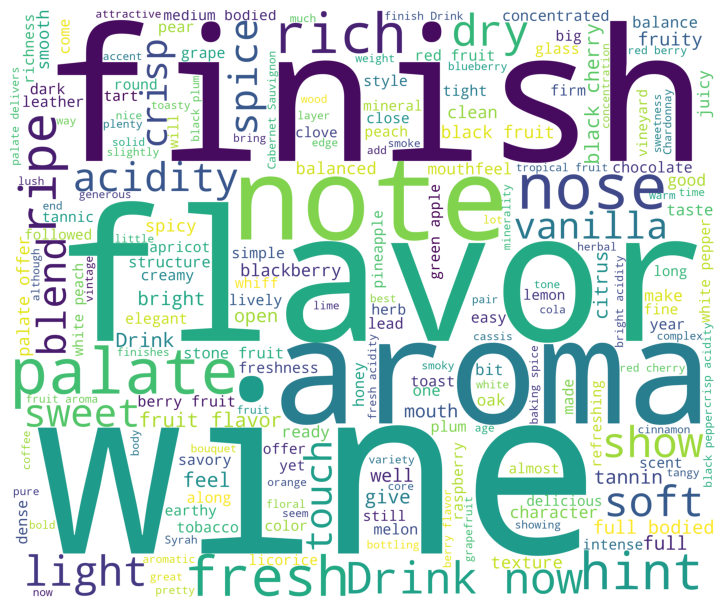

In [18]:
from wordcloud import WordCloud, STOPWORDS

# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(data['description'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)
pass

Прежде чем токенизировать текст не обходимо с ним поработать, например убрать различные "стоп-слова" и знаки пунктуации.

In [19]:
import nltk
from nltk.corpus import stopwords
from string import punctuation
english_stopwords = stopwords.words("english")

# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

data['description_clean'] = data['description'].map(lambda x: x.lower())
data['description_clean'] = data['description_clean'].map(lambda x: remove_punct(x))
data['description_clean'] = data['description_clean'].map(lambda x: x.split(' '))
data['description_clean'] = data['description_clean'].map(lambda x: [token for token in x if token not in english_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
data['description_clean'] = data['description_clean'].map(lambda x: ' '.join(x))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(data['description_clean'])

words_sparse_matrix = vectorizer.transform(data['description_clean'])
# words_df = pd.DataFrame(text_sparse_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)

# 5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)

У нас один числовой признак - цена, мы будем его нормализовывать.

In [21]:
from sklearn.preprocessing import normalize

data[['price']] = normalize(data[['price']], axis=0)

# 6. Разбить данные на обучающую и тестовую выборки

Перед разбиением необходимо объединить полученные ранее данные.

In [22]:
import scipy.sparse as sps

X = sps.hstack([data[['price']].to_numpy(), countries_sparse_matrix, words_sparse_matrix])
y = data['variety']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# 7-8. Запустить классификатор ближайших соседей, подобрать оптимальное значение к-ва ближайших соседей 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_params = {
    'n_neighbors' : [10, 15, 20, 30, 40, 50, 100],
    'p' : [1, 2]
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid=knn_params, cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [10, 15, 20, 30, 40, 50, 100],
                         'p': [1, 2]})

In [25]:
print(f"Ошибка на обучающей выборке: {1 - knn_grid.best_score_};\n\nЛучшие параметры:")
knn_grid.best_params_

Ошибка на обучающей выборке: 0.488080808080808;

Лучшие параметры:


{'n_neighbors': 40, 'p': 2}

# 9. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы 

In [26]:
y_train_pred = knn_grid.best_estimator_.predict(X_train)
y_test_pred = knn_grid.best_estimator_.predict(X_test)

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

                               precision    recall  f1-score   support

                    Aglianico       0.62      0.32      0.42        74
                     Albariño       0.58      0.60      0.59       119
                    Alvarinho       0.88      0.48      0.62        29
                      Barbera       0.45      0.61      0.52       125
                Blaufränkisch       0.71      0.49      0.58        51
                      Bonarda       0.83      0.19      0.31        26
     Bordeaux-style Red Blend       0.48      0.42      0.44       125
   Bordeaux-style White Blend       0.40      0.75      0.52       125
               Cabernet Franc       0.32      0.47      0.38       125
           Cabernet Sauvignon       0.25      0.23      0.24       125
    Cabernet Sauvignon-Merlot       0.00      0.00      0.00        29
     Cabernet Sauvignon-Syrah       0.50      0.04      0.07        25
                    Carmenère       0.55      0.94      0.69       125
     

d:\projects\ml_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\projects\ml_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\projects\ml_2023\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Общие выводы

В нашей работе использовался метод ближайших соседей, так как казалось бы что у вин сделаных из одиннаковых ингредиентов должны быть похожие описания. Некоторые сорты он достаточно хорошо определяет. Например Cabernet Sauvignon-Merlot не был найден ни разу. В целом можно попробовать другие классификаторы для поулучения более хороших результатов.